In [1]:
from google.colab import drive
drive.mount('/content/datasets')

Mounted at /content/datasets


In [2]:
path = "/content/datasets/MyDrive/preprocessed_01.csv"

In [86]:
import pandas as pd
df = pd.read_csv(path)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1205 entries, 0 to 1204
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0      1205 non-null   int64  
 1   본사정원수           1205 non-null   float64
 2   본사휴가자수          1205 non-null   float64
 3   본사출장자수          1205 non-null   float64
 4   본사시간외근무명령서승인건수  1205 non-null   float64
 5   현본사소속재택근무자수     1205 non-null   float64
 6   day             1205 non-null   int64  
 7   morning_menu    1205 non-null   object 
 8   lunch_menu      1205 non-null   object 
 9   dinner_menu     1205 non-null   object 
 10  중식계             1205 non-null   float64
 11  석식계             1205 non-null   float64
dtypes: float64(7), int64(2), object(3)
memory usage: 113.1+ KB


In [5]:
from tensorflow.keras import layers, Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [6]:
food = df['morning_menu'] 
food += df['lunch_menu']
food += df['dinner_menu']

In [7]:
food

0       ['모닝롤', '찐빵', '우유', '두유', '주스', '계란후라이', '호두죽'...
1       ['모닝롤', '단호박샌드', '우유', '두유', '주스', '계란후라이', '팥...
2       ['모닝롤', '베이글', '우유', '두유', '주스', '계란후라이', '표고버...
3       ['모닝롤', '토마토샌드', '우유', '두유', '주스', '계란후라이', '닭...
4       ['모닝롤', '와플', '우유', '두유', '주스', '계란후라이', '쇠고기죽...
                              ...                        
1200    ['모닝롤', '페퍼로니피자', '우유', '주스', '계란후라이', '찐계란', ...
1201    ['모닝롤', '생크림단팥빵', '우유', '주스', '계란후라이', '찐계란', ...
1202    ['모닝롤', 'BLT샌드위치', '우유', '주스', '계란후라이', '찐계란',...
1203    ['모닝롤', '호박고구마오븐구이', '우유', '주스', '계란후라이', '찐계란...
1204    ['모닝롤', '야채샌드', '우유', '주스', '계란후라이', '찐계란', '참...
Name: morning_menu, Length: 1205, dtype: object

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(food)

In [9]:
len(tokenizer.word_index)

3025

In [10]:
sorted(tokenizer.word_counts.items(), key=lambda x: x[1], reverse=True)[:10]

[("'포기김치'", 2962),
 ("'쌀밥'", 2744),
 ("'잡곡밥'", 1536),
 ("'주스'", 1211),
 ("'우유'", 1205),
 ("'모닝롤'", 1200),
 ("'계란후라이'", 939),
 ("'누룽지탕'", 426),
 ("'흑미밥'", 291),
 ("'스크램블에그'", 241)]

In [11]:
morning_vector = tokenizer.texts_to_sequences(df['morning_menu'])
lunch_vector = tokenizer.texts_to_sequences(df['lunch_menu'])
dinner_vector = tokenizer.texts_to_sequences(df['dinner_menu'])

In [12]:
from keras.preprocessing import sequence
max_len=9

In [92]:
morning_train_x = sequence.pad_sequences(morning_vector, maxlen=max_len)
lunch_train_x = sequence.pad_sequences(lunch_vector, maxlen=max_len)
dinner_train_x = sequence.pad_sequences(dinner_vector, maxlen=max_len)

In [93]:
morning_train_x.shape

(1205, 9)

In [95]:
other_x_train = df[['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', 'day']]

In [96]:
y_lunch = df['중식계']
y_dinner = df['석식계']

In [69]:
callbacks_list = [
    EarlyStopping(monitor='val_loss', patience=5),
    ModelCheckpoint(filepath='my_model_val.h5', monitor='val_loss', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10)
]

In [94]:
morning_train_x.shape, lunch_train_x.shape, dinner_train_x.shape

((1205, 9), (1205, 9), (1205, 9))

In [97]:
val_morning = morning_train_x[1000:]
morning_train = morning_train_x[:1000]

val_lunch = lunch_train_x[1000:]
lunch_train = lunch_train_x[:1000]

val_dinner = dinner_train_x[1000:]
dinner_train = dinner_train_x[:1000]

val_x = other_x_train[1000:]
x_train = other_x_train[:1000]

val_y_lunch = y_lunch[1000:]
y_lunch_train = y_lunch[:1000]

val_y_dinner = y_dinner[1000:]
y_dinner_train = y_dinner[:1000]

In [98]:
val_data = {
    'morning': val_morning, 'lunch': val_lunch, 'dinner': val_dinner, 'other':val_x
}

val_targets = {
    'lunch_target': val_y_lunch, 'dinner_target': val_y_dinner
}

In [99]:
val_morning.shape

(205, 9)

In [137]:
morning_input = Input(shape=(None,), dtype='int32', name='morning')
lunch_input = Input(shape=(None,), dtype='int32', name='lunch')
dinner_input = Input(shape=(None,), dtype='int32', name='dinner')
other_input = Input(shape=(6, ), dtype='float64', name='other')

embedding = layers.Embedding(len(tokenizer.word_index)+1, 32, input_length=max_len, mask_zero=True)

morning_x = embedding(morning_input)
morning_x = layers.GRU(16)(morning_x)

lunch_x = embedding(lunch_input)
lunch_x = layers.GRU(16)(lunch_x)

dinner_x = embedding(dinner_input)
dinner_x = layers.GRU(16)(dinner_x)

other_x = layers.Dense(4, activation='relu', input_shape=(6,))(other_input)

concatenated = layers.concatenate([morning_x, lunch_x, dinner_x, other_x], axis=-1)

lunch_dense = layers.Dense(16, activation='relu')(concatenated)
lunch_prediction = layers.Dense(1, name='lunch_target')(lunch_dense)

dinner_dense = layers.Dense(16, activation='relu')(concatenated)
dinner_prediction = layers.Dense(1, name='dinner_target')(dinner_dense)

model = Model([morning_input, lunch_input, dinner_input, other_input], 
              [lunch_prediction, dinner_prediction])

model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
morning (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
lunch (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
dinner (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)        (None, None, 32)     96832       morning[0][0]                    
                                                                 lunch[0][0]               

In [138]:
model.compile(optimizer='rmsprop', 
              loss='mae', 
              metrics=['mse'])

history = model.fit({'morning': morning_train, 'lunch': lunch_train, 'dinner': dinner_train, 'other':x_train}, 
                    {'lunch_target': y_lunch_train, 'dinner_target': y_dinner_train}, 
                    epochs=200, 
                    batch_size=64, 
                    callbacks=callbacks_list,
                    validation_split=0.2,
                    validation_data=(val_data, val_targets),
                    verbose=2)

Epoch 1/200
13/13 - 12s - loss: 1384.0021 - lunch_target_loss: 904.7699 - dinner_target_loss: 479.2322 - lunch_target_mse: 859086.1875 - dinner_target_mse: 247434.2188 - val_loss: 1262.5538 - val_lunch_target_loss: 835.3768 - val_dinner_target_loss: 427.1770 - val_lunch_target_mse: 746256.5625 - val_dinner_target_mse: 206316.3750
Epoch 2/200
13/13 - 1s - loss: 1382.0396 - lunch_target_loss: 903.9740 - dinner_target_loss: 478.0656 - lunch_target_mse: 857682.0625 - dinner_target_mse: 246248.5000 - val_loss: 1259.2729 - val_lunch_target_loss: 833.9585 - val_dinner_target_loss: 425.3144 - val_lunch_target_mse: 743930.7500 - val_dinner_target_mse: 204599.7031
Epoch 3/200
13/13 - 1s - loss: 1376.5132 - lunch_target_loss: 901.6282 - dinner_target_loss: 474.8850 - lunch_target_mse: 853489.7500 - dinner_target_mse: 243003.8750 - val_loss: 1250.4756 - val_lunch_target_loss: 830.1613 - val_dinner_target_loss: 420.3143 - val_lunch_target_mse: 737639.7500 - val_dinner_target_mse: 200017.9844
Epoch 

In [139]:
model.evaluate(val_data, val_targets)

7/7 [==============================] - 0s 7ms/step - loss: 332.0566 - lunch_target_loss: 206.5355 - dinner_target_loss: 125.5212 - lunch_target_mse: 65713.6562 - dinner_target_mse: 23196.6660


[332.056640625,
 206.53546142578125,
 125.52117156982422,
 65713.65625,
 23196.666015625]

In [140]:
y = model.predict(val_data)

In [141]:
y[0][:5], val_y_lunch[:5]

(array([[ 839.47046],
        [1077.4441 ],
        [1071.0242 ],
        [ 898.03406],
        [ 719.0855 ]], dtype=float32), 1000     642.0
 1001    1276.0
 1002    1019.0
 1003     967.0
 1004     804.0
 Name: 중식계, dtype: float64)

In [142]:
y[1][:5], val_y_dinner[:5]

(array([[493.18365],
        [609.5668 ],
        [631.8106 ],
        [528.1058 ],
        [294.62366]], dtype=float32), 1000    379.0
 1001    640.0
 1002    575.0
 1003    487.0
 1004    614.0
 Name: 석식계, dtype: float64)

In [143]:
import matplotlib.pyplot as plt

def drawHistory(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.figure()
    plt.plot(epochs, loss, 'ro', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    
    plt.show()

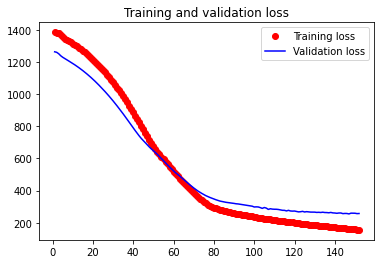

In [144]:
drawHistory(history)

In [35]:
test = pd.read_csv("/content/datasets/MyDrive/test.csv")

In [36]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50 entries, 0 to 49
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   일자              50 non-null     object 
 1   요일              50 non-null     object 
 2   본사정원수           50 non-null     int64  
 3   본사휴가자수          50 non-null     int64  
 4   본사출장자수          50 non-null     int64  
 5   본사시간외근무명령서승인건수  50 non-null     int64  
 6   현본사소속재택근무자수     50 non-null     float64
 7   조식메뉴            50 non-null     object 
 8   중식메뉴            50 non-null     object 
 9   석식메뉴            50 non-null     object 
dtypes: float64(1), int64(4), object(5)
memory usage: 4.0+ KB


In [37]:
morning_test_x = tokenizer.texts_to_sequences(test['조식메뉴'])
lunch_test_x = tokenizer.texts_to_sequences(test['중식메뉴'])
dinner_test_x = tokenizer.texts_to_sequences(test['석식메뉴'])

In [38]:
morning_test_x = sequence.pad_sequences(morning_test_x, maxlen=max_len)
lunch_test_x = sequence.pad_sequences(lunch_test_x, maxlen=max_len)
dinner_test_x = sequence.pad_sequences(dinner_test_x, maxlen=max_len)

In [39]:
morning_test_x.shape

(50, 9)

In [41]:
def change_day(x):
    if x == '월':
        return 0
    elif x == '화':
        return 1
    elif x == '수':
        return 2
    elif x == '목':
        return 3
    elif x == '금':
        return 4

In [42]:
test['day'] = test['요일'].map(change_day)

In [44]:
import numpy as np

for col in ['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수']:
    test[col] -= np.mean(test[col])
    test[col] /= np.std(test[col])

In [45]:
other_test_x = test[['본사정원수', '본사휴가자수', '본사출장자수', '본사시간외근무명령서승인건수', '현본사소속재택근무자수', 'day']]

In [46]:
other_test_x.describe()

,본사정원수,본사휴가자수,본사출장자수,본사시간외근무명령서승인건수,현본사소속재택근무자수,day
count,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,5.000000e+01,50.000000
mean,-6.279421e-15,-1.065814e-16,7.105427e-17,5.329071e-17,2.486900e-16,2.040000
std,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00,1.010153e+00,1.399125
min,-1.328592e+00,-9.555284e-01,-2.002660e+00,-1.108018e+00,-2.311834e+00,0.000000
25%,-1.328592e+00,-6.160707e-01,-8.377273e-01,-1.105103e+00,-7.934437e-01,1.000000
50%,6.942338e-01,-4.147993e-01,-1.720516e-01,2.488041e-01,3.609208e-02,2.000000
75%,7.346904e-01,9.588930e-02,9.224730e-01,8.769354e-01,6.812866e-01,3.000000
max,1.058342e+00,4.319584e+00,1.786571e+00,1.815489e+00,2.228783e+00,4.000000


In [145]:
prediction = model.predict({'morning': morning_test_x, 
                            'lunch': lunch_test_x, 
                            'dinner': dinner_test_x, 
                            'other':other_test_x})

In [146]:
prediction[0]

array([[ 13.587049],
       [ 19.008055],
       [ 19.133585],
       [256.3602  ],
       [246.4743  ],
       [201.54565 ],
       [239.21948 ],
       [ 96.885056],
       [256.84995 ],
       [216.75397 ],
       [ 48.295807],
       [223.31358 ],
       [188.48969 ],
       [103.40424 ],
       [125.612305],
       [ 78.91327 ],
       [320.37283 ],
       [351.9286  ],
       [194.20685 ],
       [229.87251 ],
       [112.83054 ],
       [210.13982 ],
       [ 83.64813 ],
       [141.00693 ],
       [ 68.67676 ],
       [307.07156 ],
       [248.99861 ],
       [111.06947 ],
       [183.24811 ],
       [ 39.049103],
       [185.3105  ],
       [ 77.01426 ],
       [ 19.951193],
       [ 69.9035  ],
       [ 91.24278 ],
       [ 96.093185],
       [ 76.173386],
       [ 30.4111  ],
       [ 38.920437],
       [ 34.642235],
       [114.76902 ],
       [117.225204],
       [ 32.325203],
       [ 44.489155],
       [ 41.631855],
       [113.69514 ],
       [114.652695],
       [ 24.0

In [148]:
len(prediction)

2

In [147]:
prediction[1]

array([[-7.02218246e+00],
       [ 6.53454113e+00],
       [ 6.58611250e+00],
       [ 1.15178978e+02],
       [ 9.96040649e+01],
       [ 6.04861412e+01],
       [ 8.12258377e+01],
       [-1.09858990e-01],
       [ 1.16809921e+02],
       [ 9.07198410e+01],
       [ 1.60407805e+00],
       [ 1.13846748e+02],
       [ 9.86622238e+01],
       [ 3.46368904e+01],
       [ 3.58266716e+01],
       [ 1.09449100e+00],
       [ 1.30112381e+02],
       [ 1.37302704e+02],
       [ 4.31498833e+01],
       [ 6.41497726e+01],
       [-1.64940262e+00],
       [ 9.04728394e+01],
       [ 7.10350418e+00],
       [ 4.43408852e+01],
       [ 1.22729969e+00],
       [ 1.36989044e+02],
       [ 1.17993996e+02],
       [ 2.89911766e+01],
       [ 6.46360092e+01],
       [ 3.05886841e+00],
       [ 9.83926926e+01],
       [ 4.27816544e+01],
       [ 6.06418991e+00],
       [ 1.99922562e+01],
       [ 2.53652649e+01],
       [ 5.40020714e+01],
       [ 4.00952530e+01],
       [ 3.42201638e+00],
       [ 4.7

In [149]:
from tensorflow.keras.models import load_model
saved_model = load_model('my_model_val.h5')

In [150]:
result = saved_model.predict({'morning': morning_test_x, 
                            'lunch': lunch_test_x, 
                            'dinner': dinner_test_x, 
                            'other':other_test_x})

In [151]:
result[0]

array([[ 13.763306],
       [ 20.220268],
       [ 22.255383],
       [241.32166 ],
       [235.33307 ],
       [196.57744 ],
       [232.87376 ],
       [102.3659  ],
       [242.21843 ],
       [206.82399 ],
       [ 51.262466],
       [208.44548 ],
       [178.90462 ],
       [102.73247 ],
       [126.73667 ],
       [ 85.47665 ],
       [303.2116  ],
       [334.8787  ],
       [191.532   ],
       [225.8376  ],
       [119.68717 ],
       [197.05699 ],
       [ 82.4226  ],
       [138.24644 ],
       [ 74.02296 ],
       [287.9812  ],
       [233.10165 ],
       [108.23425 ],
       [181.38408 ],
       [ 45.250553],
       [171.5318  ],
       [ 73.6801  ],
       [ 20.213188],
       [ 72.35383 ],
       [ 92.993904],
       [ 90.42285 ],
       [ 72.50303 ],
       [ 33.003777],
       [ 42.633633],
       [ 38.894485],
       [106.561966],
       [111.00777 ],
       [ 34.248276],
       [ 47.800472],
       [ 49.253796],
       [105.437996],
       [107.85374 ],
       [ 25.1

In [152]:
result[1]

array([[ -7.0788064 ],
       [  6.0350485 ],
       [  5.6201763 ],
       [113.50604   ],
       [ 98.023186  ],
       [ 58.984356  ],
       [ 79.33618   ],
       [ -2.3557558 ],
       [115.230736  ],
       [ 89.36937   ],
       [  0.82170594],
       [112.444756  ],
       [ 98.33981   ],
       [ 34.6987    ],
       [ 35.097332  ],
       [ -1.0410427 ],
       [127.15927   ],
       [134.05869   ],
       [ 41.076176  ],
       [ 61.62386   ],
       [ -4.481168  ],
       [ 88.29236   ],
       [  7.1500254 ],
       [ 42.896473  ],
       [ -0.5395621 ],
       [134.56876   ],
       [116.07398   ],
       [ 28.065506  ],
       [ 64.17077   ],
       [  1.7198837 ],
       [ 96.67107   ],
       [ 42.753082  ],
       [  5.716661  ],
       [ 20.982166  ],
       [ 23.529057  ],
       [ 53.08538   ],
       [ 39.94499   ],
       [  2.8232303 ],
       [  3.7049656 ],
       [  1.9406397 ],
       [ 58.70891   ],
       [ 52.173027  ],
       [  2.8568087 ],
       [  3

In [154]:
submission = pd.read_csv("/content/datasets/MyDrive/sample_submission.csv")
submission['중식계'] = result[0]
submission['석식계'] = result[1]
submission.to_csv('/content/datasets/MyDrive/val.csv', index=False)